In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AUA/Junior/sem5/Business Analytics/Project')

In [1]:
import time
import warnings
import datetime as dt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv("sales_data_sample.csv", encoding = "latin1")
print(data.__len__())
data.head()

2823


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


# Data cleaning, preparation, manipulation

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [4]:
data.describe()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP
count,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000,2823.00000,2823.000000
mean,10258.725115,35.092809,83.658544,6.466171,3553.889072,2.717676,7.092455,2003.81509,100.715551
std,92.085478,9.741443,20.174277,4.225841,1841.865106,1.203878,3.656633,0.69967,40.187912
min,10100.000000,6.000000,26.880000,1.000000,482.130000,1.000000,1.000000,2003.00000,33.000000
25%,10180.000000,27.000000,68.860000,3.000000,2203.430000,2.000000,4.000000,2003.00000,68.000000
50%,10262.000000,35.000000,95.700000,6.000000,3184.800000,3.000000,8.000000,2004.00000,99.000000
75%,10333.500000,43.000000,100.000000,9.000000,4508.000000,4.000000,11.000000,2004.00000,124.000000
max,10425.000000,97.000000,100.000000,18.000000,14082.800000,4.000000,12.000000,2005.00000,214.000000


In [5]:
data['ORDERDATE'] = pd.DatetimeIndex(data['ORDERDATE']).date
data["FULLNAME"] = data["CONTACTFIRSTNAME"] + " " + data["CONTACTLASTNAME"]

In [6]:
pd.set_option('display.max_columns', 25)

print(f'Number of Records pre cleaning: {data.shape}')
columns_with_null = [(col, f) for col in data.columns if (f:=data[col].isna().sum())>0]
print(columns_with_null)
few_nulls = list(filter(lambda x: x[1] < 100, columns_with_null))
cols_to_drop = list(filter(lambda x: x[1] > 1000, columns_with_null))
get_col_name = lambda tuple_: tuple_[0]
few_nulls = list(map(get_col_name, few_nulls))
cols_to_drop = list(map(get_col_name, cols_to_drop))
filtered = data.dropna(subset = few_nulls).copy()
filtered.drop(cols_to_drop, axis=1, inplace=True)
print(f'Number of Records post cleaning: {filtered.shape}')
filtered.head()

Number of Records pre cleaning: (2823, 26)
[('ADDRESSLINE2', 2521), ('STATE', 1486), ('POSTALCODE', 76), ('TERRITORY', 1074)]
Number of Records post cleaning: (2747, 23)


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,FULLNAME
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,10022,USA,Yu,Kwai,Small,Kwai Yu
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,51100,France,Henriot,Paul,Small,Paul Henriot
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium,Daniel Da Cunha
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,90003,USA,Young,Julie,Medium,Julie Young
5,10168,36,96.66,1,3479.76,2003-10-28,Shipped,4,10,2003,Motorcycles,95,S10_1678,Technics Stores Inc.,6505556809,9408 Furth Circle,Burlingame,94217,USA,Hirano,Juri,Medium,Juri Hirano


In [7]:
frequencies = []
cols_identical = ['PHONE', 'CUSTOMERNAME', 'FULLNAME']
for col in cols_identical:
  frequency = ''.join(list(map(str, sorted(filtered[col].value_counts().values))))
  frequencies.append(frequency)

assert len(set(frequencies)) != len(cols_identical), 'These 3 columns actually have different information'

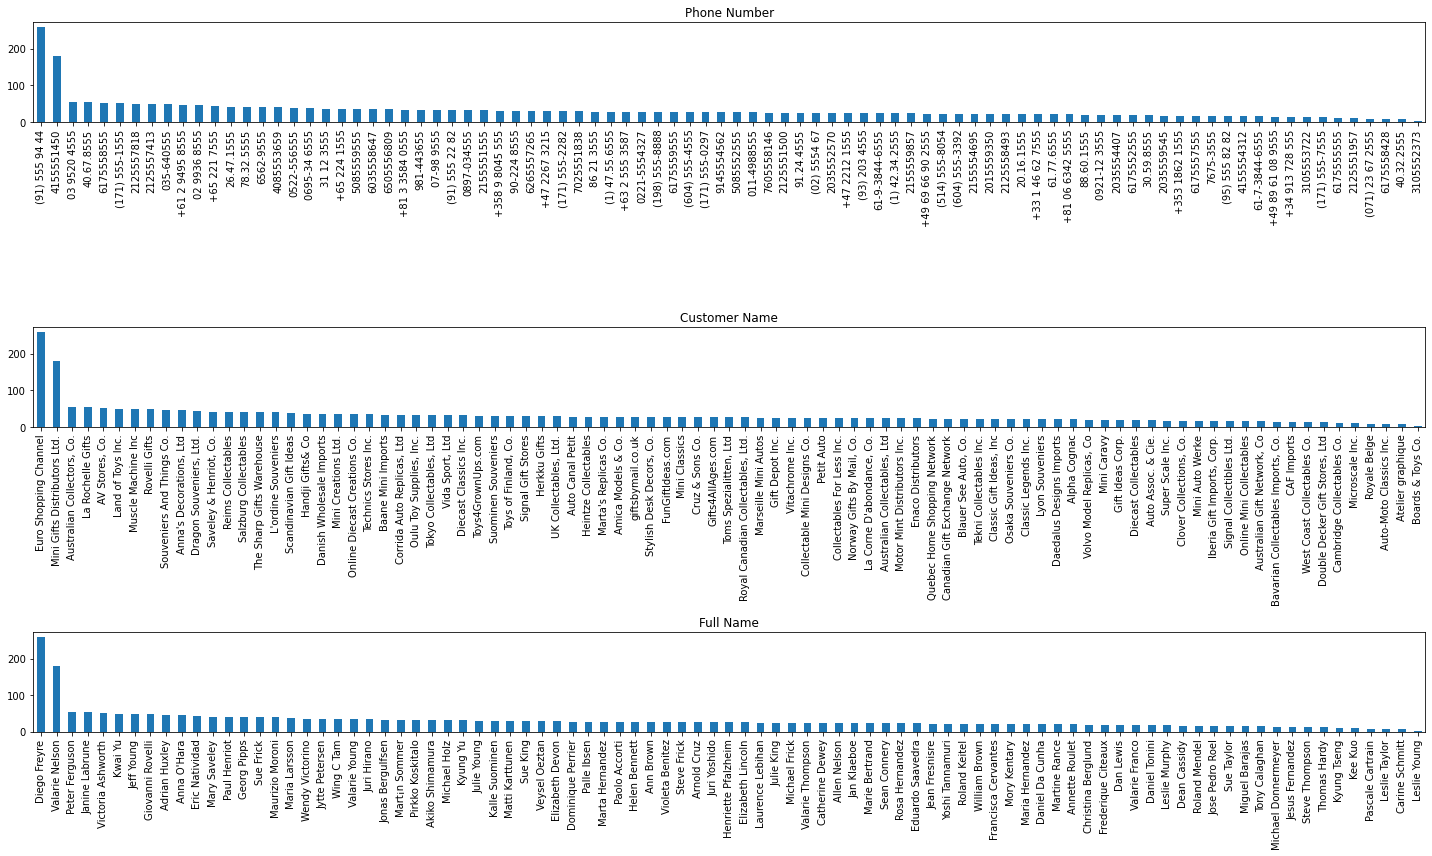

In [8]:
plt.figure(figsize=[20,12])
plt.subplot(311)
plt.title('Phone Number')
filtered.PHONE.value_counts().plot.bar();
plt.subplot(312)
plt.title('Customer Name')
filtered.CUSTOMERNAME.value_counts().plot.bar()
plt.subplot(313)
plt.title('Full Name')
filtered.FULLNAME.value_counts().plot.bar()
plt.tight_layout();

***Thus, these 3 columns contain same information !***

In [9]:
filtered.drop(['FULLNAME', 'PHONE'], axis=1, inplace=True)
filtered.tail(3)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,ADDRESSLINE1,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
2820,10386,43,100.00,4,5417.57,2005-03-01,Resolved,1,3,2005,Ships,54,S72_3212,Euro Shopping Channel,"C/ Moralzarzal, 86",Madrid,28034,Spain,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,2005-03-28,Shipped,1,3,2005,Ships,54,S72_3212,Alpha Cognac,1 rue Alsace-Lorraine,Toulouse,31000,France,Roulet,Annette,Small
2822,10414,47,65.52,9,3079.44,2005-05-06,On Hold,2,5,2005,Ships,54,S72_3212,Gifts4AllAges.com,8616 Spinnaker Dr.,Boston,51003,USA,Yoshido,Juri,Medium


In [10]:
portion = filtered.ORDERNUMBER.nunique()/len(filtered)
if portion != 1: 
  print(f'Proportion of Unique Records: {portion}, Number of Unique Orders: {portion*len(filtered)}')
  print('There are multiple records per Order (e.g. multiple products with different price bought simultaneously thorugh 1 transaction/order')
  print('Thus, need to aggregate per Order level (e.g. total money spent: Sales=PRICEEACH*QUANTITYORDERED)')

Proportion of Unique Records: 0.10848198034219148, Number of Unique Orders: 298.0
There are multiple records per Order (e.g. multiple products with different price bought simultaneously thorugh 1 transaction/order
Thus, need to aggregate per Order level (e.g. total money spent: Sales=PRICEEACH*QUANTITYORDERED)


In [11]:
agg = filtered.groupby("ORDERNUMBER", as_index=False).agg(
    Customer=pd.NamedAgg(column="CUSTOMERNAME", aggfunc="max"),   # same customer name for each order item
    Purchase_Date=pd.NamedAgg(column="ORDERDATE", aggfunc="max"), #  registered time of order all the items purchased within single order
    Total_Sales=pd.NamedAgg(column="SALES", aggfunc="sum")  # need to sum to get the total money spent on the overall order
    )

assert filtered.ORDERNUMBER.nunique() == len(agg)
agg

,ORDERNUMBER,Customer,Purchase_Date,Total_Sales
0,10100,Online Diecast Creations Co.,2003-01-06,12133.25
1,10101,"Blauer See Auto, Co.",2003-01-09,11432.34
2,10102,Vitachrome Inc.,2003-01-10,6864.05
3,10103,Baane Mini Imports,2003-01-29,54702.00
4,10104,Euro Shopping Channel,2003-01-31,44621.96
...,...,...,...,...
293,10421,Mini Gifts Distributors Ltd.,2005-05-29,7261.75
294,10422,Diecast Classics Inc.,2005-05-30,6166.80
295,10423,Petit Auto,2005-05-30,8411.95
296,10424,Euro Shopping Channel,2005-05-31,35133.34


**Let's demonstrate what we have done**

In [12]:
# take particular Order
filtered[filtered.ORDERNUMBER==10134]

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,ADDRESSLINE1,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium
56,10134,27,100.00,5,3307.77,2003-07-01,Shipped,3,7,2003,Motorcycles,118,S10_2016,Lyon Souveniers,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium
82,10134,31,100.00,4,7023.98,2003-07-01,Shipped,3,7,2003,Motorcycles,193,S10_4698,Lyon Souveniers,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Large
242,10134,20,100.00,1,2711.20,2003-07-01,Shipped,3,7,2003,Motorcycles,150,S12_2823,Lyon Souveniers,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Small
806,10134,30,61.78,6,1853.40,2003-07-01,Shipped,3,7,2003,Motorcycles,60,S18_2625,Lyon Souveniers,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Small
1468,10134,35,93.54,3,3273.90,2003-07-01,Shipped,3,7,2003,Motorcycles,112,S24_1578,Lyon Souveniers,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium
1566,10134,43,83.03,7,3570.29,2003-07-01,Shipped,3,7,2003,Motorcycles,76,S24_2000,Lyon Souveniers,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium


In [13]:
# this order has multiple things bought with different SALES values for each. We would like to aggregate those to get the total money spent on the order
print(f'Aggregated over raw form: {filtered[filtered.ORDERNUMBER==10134].SALES.sum()}')
print(f'Our aggregated: {agg[agg.ORDERNUMBER==10134].Total_Sales.values[0]}')

Aggregated over raw form: 25624.880000000005
Our aggregated: 25624.88


# RFM Analysis

## Frequency

In [14]:
data_frequency = filtered.groupby(by=["CUSTOMERNAME"], as_index=False)["ORDERNUMBER"].count()
data_frequency.columns = ["NAME", "FREQUENCY"]
print(len(data_frequency))
data_frequency.head()

89


,NAME,FREQUENCY
0,"AV Stores, Co.",51
1,Alpha Cognac,20
2,Amica Models & Co.,26
3,"Anna's Decorations, Ltd",46
4,Atelier graphique,7


## Recency

In [15]:
data_recency = filtered.groupby(by="CUSTOMERNAME", as_index=False)["ORDERDATE"].max()
data_recency.columns = ["NAME", "LASTORDERDATE"]
recent_date = data_recency["LASTORDERDATE"].max()
data_recency["RECENCY"] = data_recency["LASTORDERDATE"].apply(lambda x: (recent_date - x).days)
print(len(data_recency))
data_recency.head()

89


,NAME,LASTORDERDATE,RECENCY
0,"AV Stores, Co.",2004-11-17,195
1,Alpha Cognac,2005-03-28,64
2,Amica Models & Co.,2004-09-09,264
3,"Anna's Decorations, Ltd",2005-03-09,83
4,Atelier graphique,2004-11-25,187


## Monetary

In [16]:
data_monetary = agg.groupby(by="Customer", as_index=False)["Total_Sales"].sum()
data_monetary.columns = ["NAME", "MONETARY"]
print(len(data_monetary))
data_monetary.head()

89


,NAME,MONETARY
0,"AV Stores, Co.",157807.81
1,Alpha Cognac,70488.44
2,Amica Models & Co.,94117.26
3,"Anna's Decorations, Ltd",153996.13
4,Atelier graphique,24179.96


In [17]:
rf_data = data_recency.merge(data_frequency, on = "NAME")
rfm = rf_data.merge(data_monetary, on = "NAME")
rfm.head()

,NAME,LASTORDERDATE,RECENCY,FREQUENCY,MONETARY
0,"AV Stores, Co.",2004-11-17,195,51,157807.81
1,Alpha Cognac,2005-03-28,64,20,70488.44
2,Amica Models & Co.,2004-09-09,264,26,94117.26
3,"Anna's Decorations, Ltd",2005-03-09,83,46,153996.13
4,Atelier graphique,2004-11-25,187,7,24179.96


In [18]:
rfm['R_RANK'] = rfm['RECENCY'].rank( ascending=False) 
rfm['F_RANK'] = rfm['FREQUENCY'].rank(ascending=True)
rfm['M_RANK'] = rfm['MONETARY'].rank(ascending=True)

rfm['R_RANKnorm']=(rfm['R_RANK']/rfm['R_RANK'].max())*100
rfm['F_RANKnorm']=(rfm['F_RANK']/rfm['F_RANK'].max())*100
rfm['M_RANKnorm']=(rfm['F_RANK']/rfm['M_RANK'].max())*100

In [19]:
rfm["RFM_SCORE"] = 0.15*rfm["R_RANKnorm"] + 0.25*rfm["F_RANKnorm"] + 0.4*rfm["M_RANKnorm"]
rfm = rfm.round(0)
rfm.head()

,NAME,LASTORDERDATE,RECENCY,FREQUENCY,MONETARY,R_RANK,F_RANK,M_RANK,R_RANKnorm,F_RANKnorm,M_RANKnorm,RFM_SCORE
0,"AV Stores, Co.",2004-11-17,195,51,157808.0,38.0,85.0,81.0,44.0,96.0,96.0,69.0
1,Alpha Cognac,2005-03-28,64,20,70488.0,68.0,25.0,23.0,77.0,28.0,28.0,30.0
2,Amica Models & Co.,2004-09-09,264,26,94117.0,16.0,48.0,50.0,18.0,54.0,54.0,38.0
3,"Anna's Decorations, Ltd",2005-03-09,83,46,153996.0,65.0,80.0,80.0,73.0,90.0,90.0,70.0
4,Atelier graphique,2004-11-25,187,7,24180.0,44.0,2.0,2.0,50.0,2.0,2.0,9.0


C:\Users\zolobrine\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='RFM_SCORE', ylabel='Density'>

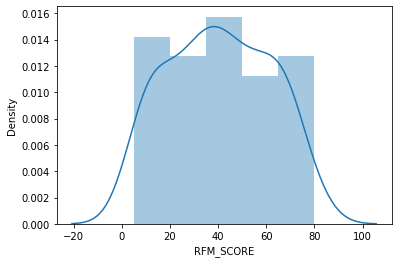

In [20]:
sns.distplot(rfm['RFM_SCORE'])

In [38]:
rfm[["NAME", "CUSTOMER_SEGMENT", "RFM_SCORE", "COUNTRY"]].to_csv("RFM_sales.csv")

## Customer Segmentation based on RFM

In [21]:
rfm["CUSTOMER_SEGMENT"] = np.where(rfm["RFM_SCORE"]<25, "LEAVING",
                                  np.where((rfm["RFM_SCORE"]>=25) & (rfm["RFM_SCORE"]<50), "RISKY",
                                          np.where((rfm["RFM_SCORE"]>=50) & (rfm["RFM_SCORE"]<75), "POTENTIAL",
                                                  "LOYAL")))
rfm.head()

,NAME,LASTORDERDATE,RECENCY,FREQUENCY,MONETARY,R_RANK,F_RANK,M_RANK,R_RANKnorm,F_RANKnorm,M_RANKnorm,RFM_SCORE,CUSTOMER_SEGMENT
0,"AV Stores, Co.",2004-11-17,195,51,157808.0,38.0,85.0,81.0,44.0,96.0,96.0,69.0,POTENTIAL
1,Alpha Cognac,2005-03-28,64,20,70488.0,68.0,25.0,23.0,77.0,28.0,28.0,30.0,RISKY
2,Amica Models & Co.,2004-09-09,264,26,94117.0,16.0,48.0,50.0,18.0,54.0,54.0,38.0,RISKY
3,"Anna's Decorations, Ltd",2005-03-09,83,46,153996.0,65.0,80.0,80.0,73.0,90.0,90.0,70.0,POTENTIAL
4,Atelier graphique,2004-11-25,187,7,24180.0,44.0,2.0,2.0,50.0,2.0,2.0,9.0,LEAVING


### Let's add Country level information for each individual customer (further plots)

In [22]:
customer2country = {}
for customer in filtered.CUSTOMERNAME.unique():
  sub_data = filtered[filtered.CUSTOMERNAME==customer]
  nested = [(k,v) for k,v in dict(sub_data.COUNTRY.value_counts()).items()]  # get values and frequencies (should be single value most cases)
  nested = sorted(nested, key = lambda x: x[1], reverse=True)  # sort by frequency & descending
  most_frequent_country = nested[0][0]  # take the 1st i.e. the most frequent tuple_[0] i.e. Name of the Country
  customer2country[customer] = str(most_frequent_country)

rfm['COUNTRY'] = rfm.NAME.map(customer2country)
rfm.head()

,NAME,LASTORDERDATE,RECENCY,FREQUENCY,MONETARY,R_RANK,F_RANK,M_RANK,R_RANKnorm,F_RANKnorm,M_RANKnorm,RFM_SCORE,CUSTOMER_SEGMENT,COUNTRY
0,"AV Stores, Co.",2004-11-17,195,51,157808.0,38.0,85.0,81.0,44.0,96.0,96.0,69.0,POTENTIAL,UK
1,Alpha Cognac,2005-03-28,64,20,70488.0,68.0,25.0,23.0,77.0,28.0,28.0,30.0,RISKY,France
2,Amica Models & Co.,2004-09-09,264,26,94117.0,16.0,48.0,50.0,18.0,54.0,54.0,38.0,RISKY,Italy
3,"Anna's Decorations, Ltd",2005-03-09,83,46,153996.0,65.0,80.0,80.0,73.0,90.0,90.0,70.0,POTENTIAL,Australia
4,Atelier graphique,2004-11-25,187,7,24180.0,44.0,2.0,2.0,50.0,2.0,2.0,9.0,LEAVING,France


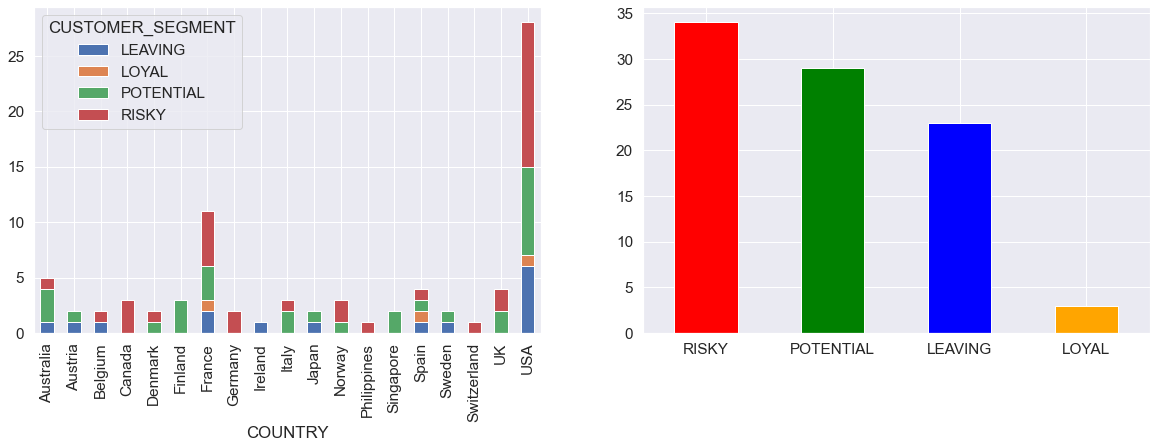

In [23]:
sns.set(font_scale=1.4)
fig, axs = plt.subplots(1, 2, figsize=[20, 10])
cross = pd.crosstab(rfm['COUNTRY'],  rfm[rfm.RFM_SCORE>10]['CUSTOMER_SEGMENT'])
ax = cross.plot(kind='bar', stacked=True, figsize=[20, 6], ax=axs[0]);
rfm['CUSTOMER_SEGMENT'].value_counts().plot(ax=axs[1], kind='bar', rot=0,
                                            color=['red', 'green', 'blue', 'orange']);

1.   We can see that Majority of Our customers are Risky. Unfortunately, the Leaving ones are almost as much as the Potential Customers while the Loyal ones are quite few. Therefore, the business is not doing good right now; hence, the business needs to perform various marketting compaings, direct reachouts, discounts, any operations that can boost the business overall peformance
2.   Looking Country level we can see that the majority of the Orders are done (most of the clients) in USA => can think of as main market. Unfortunaely here too, the same picture as in overall Distribution i.e Risky>Potential>Leaving>>Loyal. However, there are countries like Finland, Singapore and Australia where the business performs reallu well (~Champion custoemrs). While big and rich countries like Canada, Germany and Switzerland are fully under risk (Risky) and will be very pitty if the compnay does not invest time, money and resources to convert those into Potential, or even Loyals in foreseeable future.



# K-Means Clustering

First doing the K-means clustering based Recency, Frequency, and Monetary features.

In [24]:
# Select columns we are interested in
data_kmeans = rfm[["RECENCY", "FREQUENCY", "MONETARY"]]
data_kmeans.head()

,RECENCY,FREQUENCY,MONETARY
0,195,51,157808.0
1,64,20,70488.0
2,264,26,94117.0
3,83,46,153996.0
4,187,7,24180.0


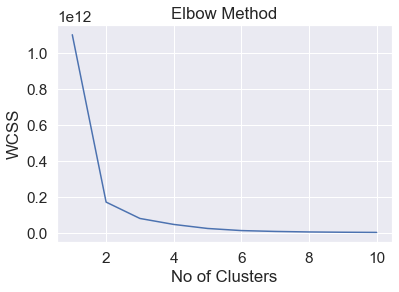

In [25]:
# Checking the Elbow graph to find the appropriate number for k
wcss= [] 
for i in range(1,11):
    k_means = KMeans(n_clusters=i, init="k-means++")
    k_means.fit(data_kmeans)
    wcss.append(k_means.inertia_)

plt.plot(range(1,11),wcss)
plt.title("Elbow Method")
plt.xlabel("No of Clusters")
plt.ylabel("WCSS")
plt.show()

The graph breaks in two points: 2 and 3 on x-axis. The angle of breaking point of 2 is more acute, so most probably the appropriate number of clusters is 2.

In [26]:
# Define k-means with clusters of 2 and 3

# With 2 clusters
model_kmeans2 = KMeans(n_clusters=2, init='k-means++', random_state=22)
y_means2 = model_kmeans2.fit_predict(data_kmeans)

# With 3 clusters
model_kmeans3 = KMeans(n_clusters=3, init='k-means++', random_state=22)
y_means3 = model_kmeans3.fit_predict(data_kmeans)

In [27]:
# Silhouette score for 2 clusters
silhouette_score(data_kmeans, y_means2)

0.9264839827121574

In [28]:
# Silhouette score for 3 clusters
silhouette_score(data_kmeans, y_means3)

0.5760983048265068

Also because the silhouette score shows a larger value for 2, we should choose 2 as the appropriate number of clusters.

In [29]:
data_kmeans["CLUSTER"] = y_means2
data_kmeans["CLUSTER"].value_counts()

C:\Users\ZOLOBR~1\AppData\Local\Temp/ipykernel_5504/2091996295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kmeans["CLUSTER"] = y_means2


0    87
1     2
Name: CLUSTER, dtype: int64

Trying K-means clustering on other features: Priceeach and Quantityordered.

In [30]:
data2_kmeans = data[["PRICEEACH", "QUANTITYORDERED"]]
data2_kmeans.head()

,PRICEEACH,QUANTITYORDERED
0,95.70,30
1,81.35,34
2,94.74,41
3,83.26,45
4,100.00,49


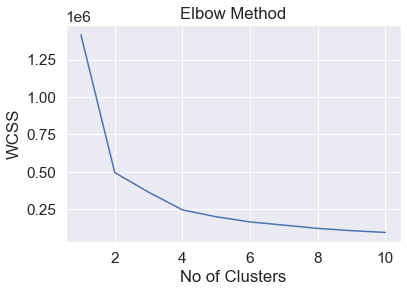

In [31]:
# Checking the Elbow graph to find the appropriate number for k
wcss= [] 
for i in range(1,11):
    k_means = KMeans(n_clusters=i, init="k-means++")
    k_means.fit(data2_kmeans)
    wcss.append(k_means.inertia_)

plt.plot(range(1,11),wcss)
plt.title("Elbow Method")
plt.xlabel("No of Clusters")
plt.ylabel("WCSS")
plt.show()

Again, the graph breaks on two points: 2 and 3.

In [32]:
# Define k-means with clusters of 2 and 3

# With 2 clusters
model2_kmeans2 = KMeans(n_clusters=2, init='k-means++', random_state=32)
y2_means2 = model2_kmeans2.fit_predict(data2_kmeans)

# With 3 clusters
model2_kmeans3 = KMeans(n_clusters=3, init='k-means++', random_state=32)
y2_means3 = model2_kmeans3.fit_predict(data2_kmeans)

In [33]:
# Silhouette score for 2 clusters
silhouette_score(data2_kmeans, y2_means2)

0.5820352721026375

In [34]:
# Silhouette score for 3 clusters
silhouette_score(data2_kmeans, y2_means3)

0.47511584540334434

Again the silhouette score is larger for 2, therefore we use 2 clusters for the algorithm.

In [35]:
data2_kmeans["CLUSTER"] = y2_means2
data2_kmeans["CLUSTER"].value_counts()

C:\Users\ZOLOBR~1\AppData\Local\Temp/ipykernel_5504/244321092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_kmeans["CLUSTER"] = y2_means2


1    1876
0     947
Name: CLUSTER, dtype: int64